In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import cv2

from sklearn.model_selection import train_test_split

%matplotlib inline

In [ ]:
!ls

sample_data  sampleSubmission.csv.zip  test.zip  train_cleaned.zip  train.zip


In [ ]:
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())

upload_files()


Saving sampleSubmission.csv.zip to sampleSubmission.csv.zip
Saving test.zip to test.zip
Saving train.zip to train.zip
Saving train_cleaned.zip to train_cleaned.zip


['sampleSubmission.csv.zip', 'test.zip', 'train.zip', 'train_cleaned.zip']

In [ ]:
import os
for dirname, _, filenames in os.walk('/content/keggle'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
path = '/content/keggle/working/'
path_zip = '/content/keggle/'

In [ ]:
# unzip files first to working directory
# We could use also unzipped data source, but why not to learn something new?
with zipfile.ZipFile(path_zip + 'train.zip', 'r') as zip_ref:
    zip_ref.extractall(path)

with zipfile.ZipFile(path_zip + 'test.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile(path_zip + 'train_cleaned.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile(path_zip + 'sampleSubmission.csv.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  

In [ ]:
# store image names in list for later use
train_img = sorted(os.listdir(path + '/train'))
train_cleaned_img = sorted(os.listdir(path + '/train_cleaned'))
test_img = sorted(os.listdir(path + '/test'))

In [ ]:
# prepare function
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    #print(img.shape)
    img = cv2.resize(img, (540, 420))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    crop_img = img[:64, :64]
    #print(crop_img.shape)
    img = np.reshape(crop_img, (64, 64, 1))
    img = np.moveaxis(img, -1, 0)
   # img = np.reshape(crop_img, (1, 420, 420))
    return img

In [ ]:
train = []
train_cleaned = []
test = []

for f in sorted(os.listdir(path + 'train/')):
    train.append(process_image(path + 'train/' + f))

for f in sorted(os.listdir(path + 'train_cleaned/')):
    train_cleaned.append(process_image(path + 'train_cleaned/' + f))
   
for f in sorted(os.listdir(path + 'test/')):
    test.append(process_image(path + 'test/' + f))

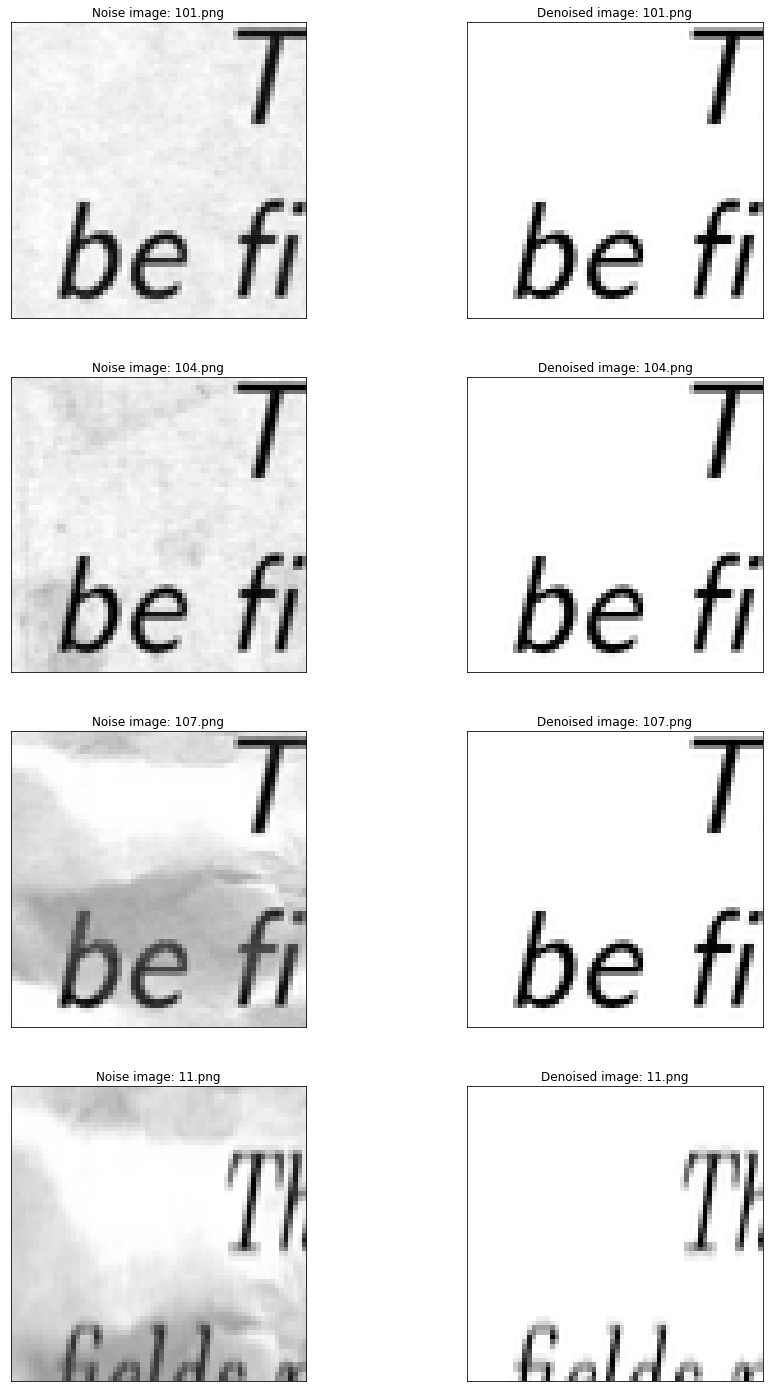

In [ ]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][0,:,:], cmap='gray')
    plt.title('Noise image: {}'.format(train_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][0,:,:], cmap='gray')
    plt.title('Denoised image: {}'.format(train_img[i]))

plt.show()

In [ ]:
# convert list to numpy array
X_train = np.asarray(train)
Y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)

In [ ]:
class Dat(torch_data.Dataset):
    def __init__(self, X, y):
        super(Dat, self).__init__()
        print(X.shape)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        
        return len(self.y)# >>> your solution here <<<
    
    def __getitem__(self, idx):
        return (self.X[idx], self.y[idx])

In [ ]:
train_dset = Dat(X_train, Y_train) 
val_dset = Dat(X_val, Y_val) 

(122, 1, 64, 64)
(22, 1, 64, 64)


In [ ]:
class MyFirstAE(nn.Module):
    def __init__(self, in_chans = 1, num_features = 16, num_of_layers = 3):
        super(MyFirstAE, self).__init__()
        layers = [torch.nn.Sequential(torch.nn.Conv2d(in_chans, num_features, kernel_size=3, stride=1, padding=1),
                                      torch.nn.ReLU(inplace=True))]
        for i in range(num_of_layers - 2):
            layers.append(torch.nn.Sequential(torch.nn.Conv2d(num_features, num_features, kernel_size=3, padding=1),
                                              torch.nn.BatchNorm2d(num_features),
                                              torch.nn.ReLU(inplace=True)))

        layers.append(torch.nn.Conv2d(num_features, in_chans, kernel_size=3, padding=1))
        self.layers = torch.nn.Sequential(*layers)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
                m.bias.data.zero_()
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.ones_(m.weight)
                torch.nn.init.zeros_(m.bias)

    def forward(self, input):
        residual = self.layers(input)

        return torch.nn.Sigmoid()(input - residual)

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as torch_data

In [ ]:
net = MyFirstAE()
net

MyFirstAE(
  (layers): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.003)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True)
device ='cpu'
train_loader = torch_data.DataLoader(train_dset, batch_size=6, shuffle=True) 
val_loader = torch_data.DataLoader(val_dset, batch_size=2, shuffle=False) 

In [ ]:
train_loader

In [ ]:
def train(epochs, net, criterion, optimizer, train_loader, val_loader,scheduler=None, verbose=True, save_dir=None):
    
    freq = max(epochs//20,1)
    net.to(device)
   
    for epoch in range(1, epochs+1):
        net.train()

        losses_train = []
        for X, _ in train_loader:
          #print(X.shape)
            ### BEGIN Solution
            # Perform one step of minibatch stochastic gradient descent
          res = net(X)
          loss = criterion(res, X)
          losses_train.append(loss)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

       # loss_mean = losses_train  / len(train_loader)
        # define NN evaluation, i.e. turn off dropouts, batchnorms, etc.
        net.eval()
        losses_val = []
        for X, _ in val_loader:
            #losses_val = []
            res = net(X)
            # Compute the validation loss
            valid_loss = criterion(res, X)  
            losses_val.append(valid_loss)
       # val_loss_mean = losses_val / len(val_loader)
            ### END Solution    
            ### MYEXTRA CODE STARTS
        if scheduler is not None:
            scheduler.step(valid_loss)
            ### MYEXTRA CODE ENDS
        #if verbose and epoch%freq==0:
        mean_val = sum(losses_val)/len(losses_val)
        mean_train = sum(losses_train)/len(losses_train)

        print('Epoch {}/{} || Loss:  Train {:.4f} | Validation {:.4f}'\
              .format(epoch, epochs, mean_train, mean_val))

In [ ]:
train(100, net, criterion, optimizer, train_loader, val_loader, scheduler) 

Epoch 1/100 || Loss:  Train 0.0128 | Validation 0.0102
Epoch 2/100 || Loss:  Train 0.0020 | Validation 0.0028
Epoch 3/100 || Loss:  Train 0.0011 | Validation 0.0011
Epoch 4/100 || Loss:  Train 0.0009 | Validation 0.0007
Epoch 5/100 || Loss:  Train 0.0007 | Validation 0.0006
Epoch 6/100 || Loss:  Train 0.0008 | Validation 0.0022
Epoch 7/100 || Loss:  Train 0.0006 | Validation 0.0006
Epoch 8/100 || Loss:  Train 0.0006 | Validation 0.0010
Epoch 9/100 || Loss:  Train 0.0005 | Validation 0.0006
Epoch 10/100 || Loss:  Train 0.0005 | Validation 0.0030
Epoch 11/100 || Loss:  Train 0.0005 | Validation 0.0004
Epoch 12/100 || Loss:  Train 0.0004 | Validation 0.0005
Epoch 13/100 || Loss:  Train 0.0004 | Validation 0.0008
Epoch 14/100 || Loss:  Train 0.0004 | Validation 0.0005
Epoch 15/100 || Loss:  Train 0.0004 | Validation 0.0006
Epoch 16/100 || Loss:  Train 0.0003 | Validation 0.0003
Epoch 17/100 || Loss:  Train 0.0004 | Validation 0.0002
Epoch 18/100 || Loss:  Train 0.0003 | Validation 0.0005
E